In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
!pip install keras-core --upgrade
!pip install -q keras-nlp --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 415.4/415.4 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 73.2 MB/s eta 0:00:00


In [3]:
# -*- coding: utf-8 -*-
"""
R_001_Research_Project__
|
R_001_binary_text_classification_related_not_related.ipynb
Created on Thu Jan 18 16:30:03 2024
@author: Rochana Obadage
"""

import os
os.environ['KERAS_BACKEND'] = 'tensorflow'

from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from datetime import datetime

import numpy as np
import pandas as pd
import tensorflow as tf
import keras_core as keras
import keras_nlp
import pytz
import re
import argparse
import sys

Using TensorFlow backend


In [4]:
!python3 -c "import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))"

2024-01-31 02:06:59.665236: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-31 02:06:59.665291: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-31 02:06:59.667004: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-31 02:07:01.936237: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
[]


# Load the datasets
```for_training.csv```

```

They contain
    context -- text
    label_scored:{ -2, -1, 0, 0.5, 1 }
    labeln:{"O-NR", "P-NR", "Neutral", "Weak", "Strong"}
```t

In [2]:
!ls
!pwd

In [6]:
df_dataset = pd.read_csv("dataset/for_training.csv")
df_dataset

,context,label_score,label
0,"Recently, several losses [18], [24], [25] cons...",0.0,Neutral
1,The subsequent designs consider multiple negat...,0.0,Neutral
2,"the mainstream methods [1], [5], [6], [18], [6...",0.0,Neutral
3,"Accordingly, several works [24], [25] based on...",0.0,Neutral
4,The proposed method can be seamlessly implante...,0.5,Weak
...,...,...,...
1932,A Jain [125] suggests training a deep network ...,0.0,Neutral
1933,[39]12 2021 No name ICDAR PubTabNet ICDAR 2019...,0.0,Neutral
1934,The source codes of 6 papers were not executab...,-2.0,O-NR
1935,The success of DL has marked the revisiting of...,0.0,Neutral


In [13]:
df_dataset['binary_label'] = df_dataset['label_score'].apply(lambda x: 'not_related' if x == 0.0 else 'related')
df_dataset

,context,label_score,label,binary_label
0,"Recently, several losses [18], [24], [25] cons...",0.0,Neutral,not_related
1,The subsequent designs consider multiple negat...,0.0,Neutral,not_related
2,"the mainstream methods [1], [5], [6], [18], [6...",0.0,Neutral,not_related
3,"Accordingly, several works [24], [25] based on...",0.0,Neutral,not_related
4,The proposed method can be seamlessly implante...,0.5,Weak,related
...,...,...,...,...
1932,A Jain [125] suggests training a deep network ...,0.0,Neutral,not_related
1933,[39]12 2021 No name ICDAR PubTabNet ICDAR 2019...,0.0,Neutral,not_related
1934,The source codes of 6 papers were not executab...,-2.0,O-NR,related
1935,The success of DL has marked the revisiting of...,0.0,Neutral,not_related


In [11]:
df_ = df_dataset.groupby('binary_label').count()
df_.reset_index()

,binary_label,context,label_score,label
0,not_related,1756,1756,1756
1,related,181,181,181


In [12]:
df_ = df_dataset.groupby('label').count()
df_.reset_index()

,label,context,label_score,binary_label
0,Neutral,1756,1756,1756
1,O-NR,12,12,12
2,P-NR,11,11,11
3,Strong,19,19,19
4,Weak,139,139,139


In [20]:
df_dataset['target'] = df_dataset['binary_label'].apply(lambda x: 0 if x == "not_related" else 1)
df_dataset

,context,label_score,label,binary_label,target
0,"Recently, several losses [18], [24], [25] cons...",0.0,Neutral,not_related,0
1,The subsequent designs consider multiple negat...,0.0,Neutral,not_related,0
2,"the mainstream methods [1], [5], [6], [18], [6...",0.0,Neutral,not_related,0
3,"Accordingly, several works [24], [25] based on...",0.0,Neutral,not_related,0
4,The proposed method can be seamlessly implante...,0.5,Weak,related,1
...,...,...,...,...,...
1932,A Jain [125] suggests training a deep network ...,0.0,Neutral,not_related,0
1933,[39]12 2021 No name ICDAR PubTabNet ICDAR 2019...,0.0,Neutral,not_related,0
1934,The source codes of 6 papers were not executab...,-2.0,O-NR,related,1
1935,The success of DL has marked the revisiting of...,0.0,Neutral,not_related,0


In [21]:
# taking only a portion from '0' and '0.5' to make the classes balanced
df_dataset_related = df_dataset[df_dataset['binary_label'] =='related']
df_dataset_not_related = df_dataset[df_dataset['binary_label'] =='not_related'].sample(n=181, replace=False)

df_balanced = pd.concat([df_dataset_related, df_dataset_not_related], ignore_index = True)
df_balanced.to_csv(r"dataset/for_binary_training_balanced.csv", index=False)
df_balanced

,context,label_score,label,binary_label,target
0,The proposed method can be seamlessly implante...,0.5,Weak,related,1
1,To further demonstrate the effectiveness of Bi...,0.5,Weak,related,1
2,"focusing on the feature fusion [39], [49] with...",0.5,Weak,related,1
3,"To improve embedding quality, detaching class-...",0.5,Weak,related,1
4,We compared the performance of our likelihood ...,0.5,Weak,related,1
...,...,...,...,...,...
357,DeepDeSRT [3] uses the fuzzy cognitive network...,0.0,Neutral,not_related,0
358,Zhou et al. (2021) integrate features from ext...,0.0,Neutral,not_related,0
359,Then we compare LORE with models mining the ad...,0.0,Neutral,not_related,0
360,"To identify rows and columns in tables, KA Has...",0.0,Neutral,not_related,0


In [22]:
df_b = df_balanced.groupby('binary_label').count()
df_b.reset_index()

,binary_label,context,label_score,label,target
0,not_related,181,181,181,181
1,related,181,181,181,181


In [4]:
# lable names
print(set(df_dataset['label']))
print(set(df_dataset['binary_label']))
print(set(df_dataset['target']))

In [25]:
test_size =0.2

df_train, df_test = train_test_split(df_balanced, test_size=0.2,stratify=df_balanced.label.values)

In [26]:
df_1 = df_train.groupby('binary_label').count()
df_1.reset_index()

,binary_label,context,label_score,label,target
0,not_related,144,144,144,144
1,related,145,145,145,145


In [27]:
df_2 = df_test.groupby('binary_label').count()
df_2.reset_index()

,binary_label,context,label_score,label,target
0,not_related,37,37,37,37
1,related,36,36,36,36


In [28]:
df_train.to_csv(r"dataset/binary_train.csv",index=False)
df_test.to_csv(r"dataset/binary_test.csv",index=False)

In [4]:
df_train = pd.read_csv("dataset/binary_train.csv")
df_test = pd.read_csv("dataset/binary_test.csv")

print('Training Set Shape = {}'.format(df_train.shape))
print('Training Set Memory Usage = {:.2f} MB'.format(df_train.memory_usage().sum() / 1024**2))
print('Test Set Shape = {}'.format(df_test.shape))
print('Test Set Memory Usage = {:.2f} MB'.format(df_test.memory_usage().sum() / 1024**2))

Training Set Shape = (289, 5)
Training Set Memory Usage = 0.01 MB
Test Set Shape = (73, 5)
Test Set Memory Usage = 0.00 MB


In [5]:
df_train.head()

,context,label_score,label,binary_label,target
0,[8] recently reported an F-score of 0.,-2.0,O-NR,related,1
1,This reproducibility study focuses on 4 Antoni...,1.0,Strong,related,1
2,The comparison of performance between open sou...,0.5,Weak,related,1
3,provide an analysis of how various factors inv...,0.0,Neutral,not_related,0
4,"Therefore, we firstly generate a synthetic dat...",0.5,Weak,related,1


In [6]:
df_test.head()

,context,label_score,label,binary_label,target
0,The goal of LGPMA [37] is to obtain better ali...,0.0,Neutral,not_related,0
1,The source codes of 6 papers were not executab...,-2.0,O-NR,related,1
2,Abstract—Based on the recent advancements in t...,0.0,Neutral,not_related,0
3,We develop on the insights of Antoniak and Mim...,0.5,Weak,related,1
4,"(Hsieh et al., 2019) proposes an elegant learn...",0.0,Neutral,not_related,0


# Explore the dataset

In [7]:
df_train["length"] = df_train["context"].apply(lambda x : len(x))
df_test["length"] = df_test["context"].apply(lambda x : len(x))

print("Train Length Stat")
print(df_train["length"].describe())
print()

print("Test Length Stat")
print(df_test["length"].describe())

Train Length Stat
count    289.000000
mean     174.653979
std      100.962304
min       38.000000
25%      111.000000
50%      155.000000
75%      214.000000
max      957.000000
Name: length, dtype: float64

Test Length Stat
count     73.000000
mean     170.123288
std       66.093777
min       31.000000
25%      120.000000
50%      169.000000
75%      209.000000
max      411.000000
Name: length, dtype: float64


# Preprocess the data

In [48]:
BATCH_SIZE = 32
NUM_TRAINING_EXAMPLES = df_train.shape[0]
TRAIN_SPLIT = 0.9
VAL_SPLIT = 0.1
STEPS_PER_EPOCH = int(NUM_TRAINING_EXAMPLES)*TRAIN_SPLIT // BATCH_SIZE

EPOCHS = 20 #8
AUTO = tf.data.experimental.AUTOTUNE
NUM_TRAINING_EXAMPLES

289

In [10]:
from sklearn.model_selection import train_test_split

X = df_train["context"]
y = df_train["target"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=VAL_SPLIT, random_state=42, stratify=df_train.label.values)
# stratify=df_balanced.label.values

X_test = df_test["context"]
y_test = df_test["target"]

set(y)

{0, 1}

In [11]:
len(y_train)

260

In [12]:
len(y_val)

29

In [49]:
# Load a DistilBERT model.
preset= "distil_bert_base_en_uncased"

# Use a shorter sequence length.
preprocessor = keras_nlp.models.DistilBertPreprocessor.from_preset(preset,
                                                                   sequence_length=512,
                                                                   )
# preprocessor_4_tweets
# Pretrained classifier.
classifier = keras_nlp.models.DistilBertClassifier.from_preset(preset,
                                                               preprocessor = preprocessor,
                                                               num_classes=2)

classifier.summary()

/usr/local/lib/python3.10/dist-packages/keras_nlp/src/models/backbone.py:37: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/usr/local/lib/python3.10/dist-packages/keras_nlp/src/models/backbone.py:37: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids


Preprocessor: "distil_bert_preprocessor_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ distil_bert_tokenizer (DistilBertTokenizer)        │                                              30,522 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "distil_bert_classifier_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                  ┃ Output Shape                           ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)                     │ (None, None)                           │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ token_ids (InputLayer)                        │ (None, None)                           │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ distil_bert_backbone (DistilBertBackbone)     │ (None, None, 768)                      │      66,362,880 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ tf.__operators__.getitem_1 (SlicingOpLambda)  │ (None, 768)                            │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ pooled_dense (Dense)                          │ (None, 768)                            │         590,592 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ classifier_dropout (Dropout)                  │ (None, 768)                            │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ logits (Dense)                                │ (None, 2)                              │           1,538 │
└───────────────────────────────────────────────┴────────────────────────────────────────┴─────────────────┘

 Total params: 66,955,010 (255.41 MB)

 Trainable params: 66,955,010 (255.41 MB)

 Non-trainable params: 0 (0.00 B)

# Train your own model, fine-tuning BERT

In [ ]:
classifier.fit(x=X_train, y=y_train, batch_size=2)

# Re-compile (e.g., with a new learning rate)
classifier.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(1e-5),
    metrics= ["accuracy"],
)

history = classifier.fit(x=X_train,
                         y=y_train,
                         batch_size=BATCH_SIZE,
                         epochs=EPOCHS,
                         validation_data=(X_val, y_val),
                        )

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


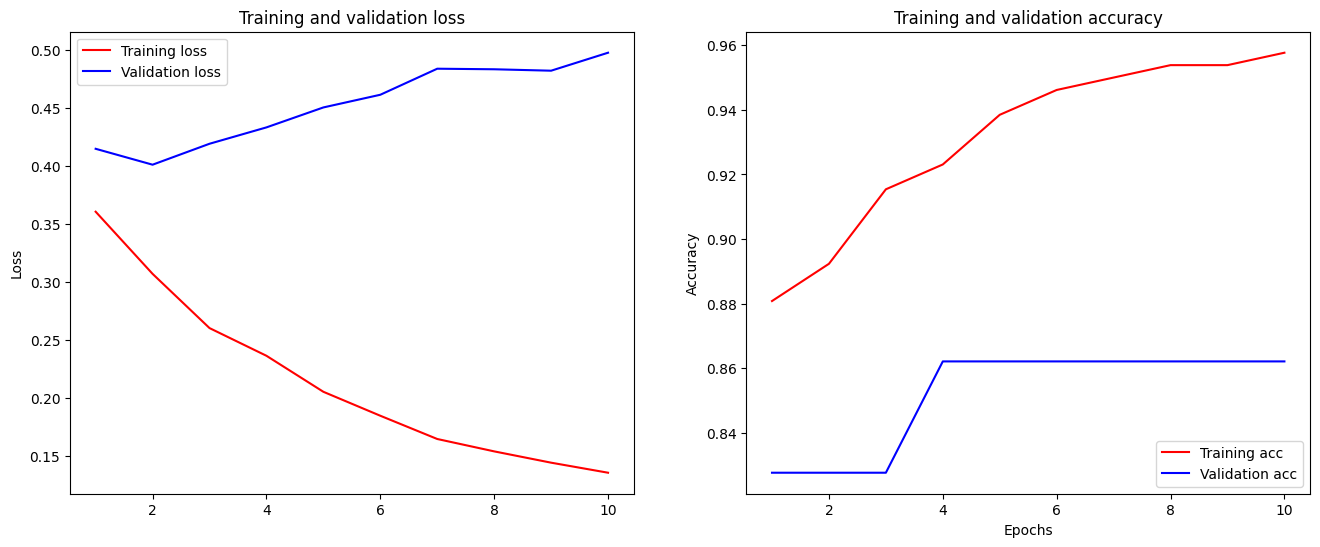

In [15]:
from matplotlib import pyplot as plt

history_dict = history.history
print(history_dict.keys())

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(16, 6))
fig.tight_layout()

plt.subplot(1, 2, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')


In [16]:
saved_model_path = 'lemos_R_001_label_predictor_004_30ep_bert.keras'
classifier.save(saved_model_path)

/usr/local/lib/python3.10/dist-packages/keras_nlp/src/models/task.py:47: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/usr/local/lib/python3.10/dist-packages/keras_nlp/src/models/task.py:47: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids


In [ ]:
model_path = 'lemos_R_001_label_predictor_004_30ep_bert.keras'
reloaded_model_22 = tf.keras.models.load_model(model_path)

/usr/local/lib/python3.10/dist-packages/keras_nlp/src/models/task.py:47: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/usr/local/lib/python3.10/dist-packages/keras_nlp/src/models/task.py:47: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/usr/local/lib/python3.10/dist-packages/keras_nlp/src/models/backbone.py:37: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/usr/local/lib/python3.10/dist-packages/keras_nlp/src/models/backbone.py:37: UserWarning: 

# Predictions

In [43]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
def plot_confusion_matrix(y_true, y_preds, labels=None, type_="Test",normalize_="true"):
  cm = confusion_matrix(y_true, y_preds)
  cm = confusion_matrix(y_true, y_preds, normalize=normalize_)
  fig, ax = plt.subplots(figsize=(6, 6))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
#   disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
  disp.plot(cmap="Blues", ax=ax, colorbar=False)
  plt.title(f"{type_} confusion matrix")
  plt.savefig(f'plots/{type_}.png')
  plt.show()

In [17]:
y_pred_train = classifier.predict(X_train)
y_pred_val = classifier.predict(X_val)
y_pred_test = classifier.predict(X_test)


3/3 [==============================] - 2s 445ms/step


# training : confusion-matrix

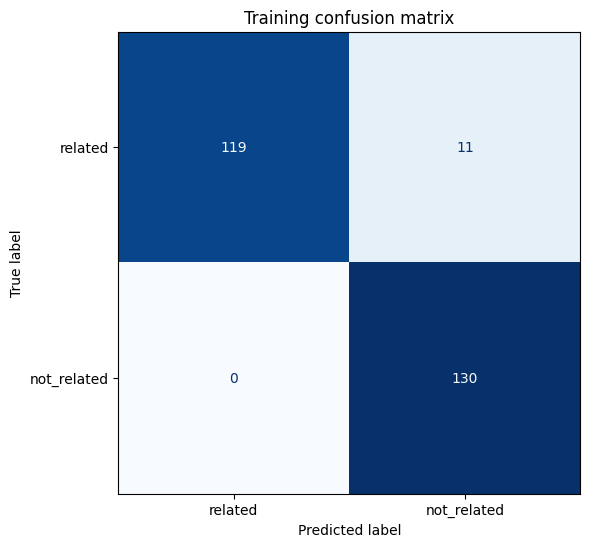

In [44]:
# training
label_to_score = {'related':1,"not_related":0}

plot_confusion_matrix(y_train, np.argmax(y_pred_train, axis=1),labels= label_to_score.keys(),type_="Training",normalize_=None)  #normalize_="true" -- default

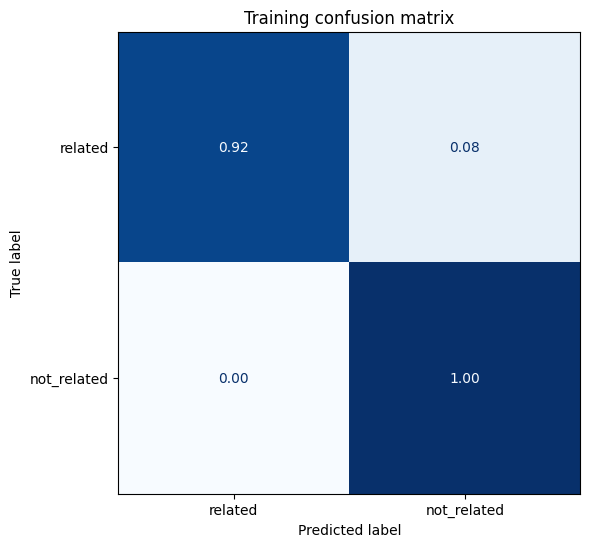

In [22]:
# training
plot_confusion_matrix(y_train, np.argmax(y_pred_train, axis=1),labels= label_to_score.keys(),type_="Training")

In [23]:
from sklearn.metrics import classification_report
print('classifiation report : Training')
print(classification_report(y_train, np.argmax(y_pred_train, axis=1),target_names= label_to_score.keys()))

classifiation report : Training
              precision    recall  f1-score   support

     related       1.00      0.92      0.96       130
 not_related       0.92      1.00      0.96       130

    accuracy                           0.96       260
   macro avg       0.96      0.96      0.96       260
weighted avg       0.96      0.96      0.96       260



# validation : confusion-matrix

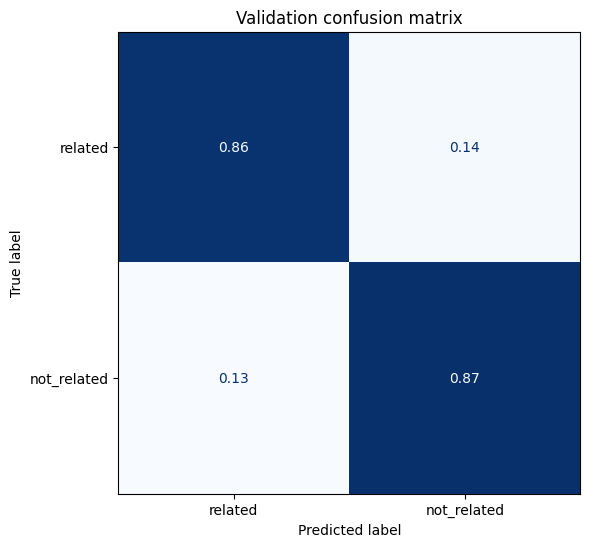

In [24]:
# validation
plot_confusion_matrix(y_val, np.argmax(y_pred_val, axis=1),labels= label_to_score.keys(),type_="Validation")

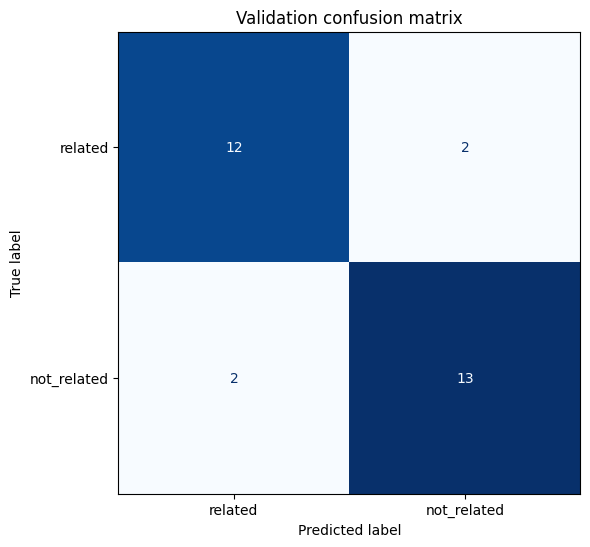

In [45]:
plot_confusion_matrix(y_val, np.argmax(y_pred_val, axis=1),labels= label_to_score.keys(),type_="Validation",normalize_=None)  #normalize_="true" -- default

In [26]:
from sklearn.metrics import classification_report
print('classifiation report: Validation')
print(classification_report(y_val, np.argmax(y_pred_val, axis=1),target_names= label_to_score.keys()))

classifiation report: Validation
              precision    recall  f1-score   support

     related       0.86      0.86      0.86        14
 not_related       0.87      0.87      0.87        15

    accuracy                           0.86        29
   macro avg       0.86      0.86      0.86        29
weighted avg       0.86      0.86      0.86        29



# Testing : confusion-matrix

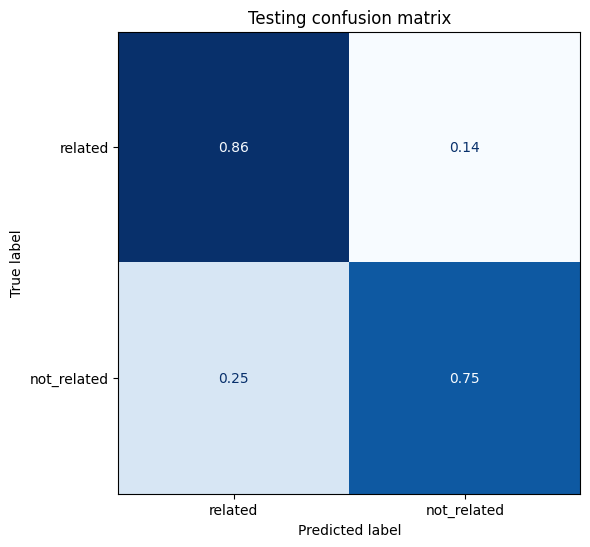

In [27]:
# Testing
plot_confusion_matrix(y_test, np.argmax(y_pred_test, axis=1),labels= label_to_score.keys(),type_="Testing")

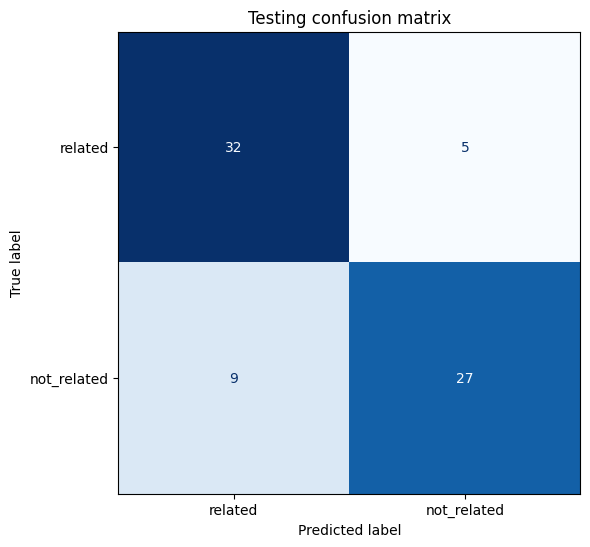

In [46]:
plot_confusion_matrix(y_test, np.argmax(y_pred_test, axis=1),labels= label_to_score.keys(),type_="Testing",normalize_=None)  #normalize_="true" -- default

In [29]:
from sklearn.metrics import classification_report
print('classifiation report: Testing')
print(classification_report(y_test, np.argmax(y_pred_test, axis=1),target_names= label_to_score.keys()))

classifiation report: Testing
              precision    recall  f1-score   support

     related       0.78      0.86      0.82        37
 not_related       0.84      0.75      0.79        36

    accuracy                           0.81        73
   macro avg       0.81      0.81      0.81        73
weighted avg       0.81      0.81      0.81        73



In [ ]:
!pwd
import glob
label_file_list = [i for i in glob.glob("automated_labelling/*.csv")]

label_file_list
df_test_1 = pd.read_csv(label_file_list[12])

/content/drive/MyDrive/ODU/Research_ODU/R001_Fall_2023_AI_Reproducibility/model_training


In [ ]:
label_file_list = [i for i in glob.glob("automated_labelling/*.csv")]

label_file_list
df_test_1 = pd.read_csv(label_file_list[12])

for file_ in label_file_list:
    filename = file_.replace("automated_labelling/","")
    print(filename)

RS_015_MLRC_2022_15.csv
RS_033_MLRC_2022_33.csv
RS_037_MLRC_2022_37.csv
RS_012_MLRC_2022_12.csv
RS_039_MLRC_2022_39.csv
RS_010_MLRC_2022_10.csv
RS_001_MLRC_2022_01.csv
RS_020_MLRC_2022_20.csv
RS_027_MLRC_2022_27.csv
RS_030_MLRC_2022_30.csv
RS_032_MLRC_2022_32.csv
RS_031_MLRC_2022_31.csv
RS_018_MLRC_2022_18.csv
RS_005_MLRC_2022_05.csv
RS_013_MLRC_2022_13.csv
RS_016_MLRC_2022_16.csv
RS_008_MLRC_2022_08.csv
RS_024_MLRC_2022_24.csv
RS_007_MLRC_2022_07.csv
RS_002_MLRC_2022_02.csv
RS_035_MLRC_2022_35.csv
RS_014_MLRC_2022_14.csv
RS_003_MLRC_2022_03.csv
RS_025_MLRC_2022_25.csv
RS_004_MLRC_2022_04.csv
RS_009_MLRC_2022_09.csv
RS_006_MLRC_2022_06.csv
RS_021_MLRC_2022_21.csv
RS_028_MLRC_2022_28.csv
RS_023_MLRC_2022_23.csv
RS_038_MLRC_2022_38.csv
RS_026_MLRC_2022_26.csv
RS_011_MLRC_2022_11.csv
RS_034_MLRC_2022_34.csv
RS_019_MLRC_2022_19.csv
RS_022_MLRC_2022_22.csv
RS_036_MLRC_2022_36.csv
RS_017_MLRC_2022_17.csv
RS_029_MLRC_2022_29.csv
RS_042_MLRC_2022_42.csv
RS_041_MLRC_2022_41.csv
RS_050_MLRC_2021

In [ ]:
df_test_1

,text,label_score,label
0,"” The sources of unfairness are many, includin...",NaN,NaN
1,"Within the domain of algorithmic fairness, our...",NaN,NaN
2,"For software properties such as fairness [3], ...",NaN,NaN
3,empirically compared Seldonian algorithms to o...,NaN,NaN
4,"contextual bandits [31], the setting where the...",NaN,NaN
5,Probabilistic verification has successfully pr...,NaN,NaN
6,"There are some works [Rezaei et al., 2021, Sch...",NaN,NaN
7,The ability to measure the stability of chosen...,NaN,NaN
8,Recent works have studied fair classification ...,NaN,NaN
9,The above assumptions are used in the theoreti...,NaN,NaN


In [ ]:
df_test_2 = pd.read_csv("dataset/test.csv")

In [ ]:
df_test_2

,context,label_score,label,target
0,"As shown in Table 4, the re-implemented SPLERG...",-2.0,O-NR,0
1,"Also based on DGCNN, TabStructNet [36] is prop...",0.0,Neutral,2
2,Table structure recognizer is our own implemen...,0.5,Weak,3
3,Splitting Model Merging Model Performance(Pubt...,0.0,Neutral,2
4,Note that LGPMA requires additional\nannotatio...,-1.0,P-NR,1
5,[28] 2019 DeeptabSTR ICDAR TabStructDB ICDAR 2...,0.0,Neutral,2
6,In this section we analyze two popular benchma...,0.5,Weak,3
7,We use FinTabNet [41] dataset for training.,0.5,Weak,3
8,"Inspired by the analysis, we designed a simple...",1.0,Strong,4
9,Secondly we pick the best hyper-parameters fou...,0.0,Neutral,2


In [ ]:
predictions_df = df_test_1.copy()
predictions_df['target_predict'] = 0
x_test_series = predictions_df['text']

predictions = reloaded_model_22.predict(x_test_series)
predictions_df["target_predict"] = np.argmax(predictions, axis=1)

mapping = {'O-NR':0, 'P-NR':1, 'Neutral':2, 'Weak':3, 'Strong':4}
mapping_reverse = {0: 'O-NR', 1: 'P-NR', 2: 'Neutral', 3: 'Weak', 4: 'Strong'}
label_to_score = {'O-NR': -2, 'P-NR': -1, 'Neutral': 0, 'Weak': 0.5, 'Strong': 1}

predictions_df['label'] = predictions_df["target_predict"].map(mapping_reverse)
predictions_df['label_score'] = predictions_df["label"].map(label_to_score)

predictions_df

2/2 [==============================] - 54s 9s/step


,text,label_score,label,target_predict
0,"” The sources of unfairness are many, includin...",0.0,Neutral,2
1,"Within the domain of algorithmic fairness, our...",1.0,Strong,4
2,"For software properties such as fairness [3], ...",0.0,Neutral,2
3,empirically compared Seldonian algorithms to o...,0.5,Weak,3
4,"contextual bandits [31], the setting where the...",0.0,Neutral,2
5,Probabilistic verification has successfully pr...,0.0,Neutral,2
6,"There are some works [Rezaei et al., 2021, Sch...",0.0,Neutral,2
7,The ability to measure the stability of chosen...,0.0,Neutral,2
8,Recent works have studied fair classification ...,0.0,Neutral,2
9,The above assumptions are used in the theoreti...,0.5,Weak,3
